## Parameter search experiments

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from consensus_clustering.load_data import load_fuzzy_data
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
# from scipy.spatial import distance
# from copy import deepcopy
# from timeit import default_timer as timer
# from datetime import timedelta
# import importlib
%matplotlib inline

In [2]:
fuzzy = load_fuzzy_data()
len(fuzzy)

2309

In [60]:
def param_search_dbscan(data, k_consensus, recluster_what, recluster_how, eps_arr, min_pts_arr):
    num_objects = len(eps_arr)
    dbscan_objects = [None] * num_objects
    dbscan_obj = None

    print("Fit DBSCAN objects")

    # Fit DBSCAN objects
    for i, (eps, minPts) in enumerate(zip(eps_arr, min_pts_arr)):
        dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
        dbscan_obj.fit()
        dbscan_objects[i] = dbscan_obj

    print("Fit consensus")

    # Fit consensus
    clusterings = [*dbscan_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(dbscan_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, dbscan_objects, consensus_obj

In [61]:
def param_search_kmeans(data, k_consensus, recluster_what, recluster_how, k_arr):
    num_objects = len(k_arr)
    kmeans_objects = [None] * num_objects
    kmeans_obj = None

    print("Fit kmeans objects")

    # Fit kmeans objects
    for i, k in enumerate(k_arr):
        kmeans_obj = cl_dist.KMeans(data=data, k=k, verbose=False)
        kmeans_obj.fit()
        kmeans_objects[i] = kmeans_obj

    print("Fit consensus")

    # Fit consensus
    clusterings = [*kmeans_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(kmeans_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, kmeans_objects, consensus_obj

Kann ich k von kMeans überhaupt verwenden? Ich muss ja schon ein k angeben für den consensus! -> ist natürlich dämlich. ^^ Wäre das Beste, was ich herausholen kann, evtl. dass ich beim consensus auch ein schlechtes k angeben kann, und es funktioniert immer noch? Oder gibt es auch eine consensus-Methode, bei der man die Anzahl der Cluster nicht angeben muss?

## ALS NÄCHSTES:
+ 2d-param-search
+ behebe diese beknackte Warnung: C:\Users\Johannes\Desktop\Uni\Mathematische Aspekte in ML\Projekt\consensus - playing around afterwards\clustertools\models\consensus.py:202: RuntimeWarning: invalid value encountered in double_scalars
  return mutual_information / np.sqrt(entropy_a * entropy_b)

In [69]:
# Set parameters:

# General
data = fuzzy
k_consensus = 10
recluster_what = 'points'
recluster_how = 'hierarchical'
num_objects = 22

# DBSCAN
# eps_arr = np.linspace(0.01, 0.10, num_objects)
# WIE GING DAS NOCH MAL MIT DEM PRODUKT, DASS DIE ARRAYS RICHTIG BESETZT SIND?
min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_arr = np.ones(num_objects).astype(int) * min_pts

# KMeans
k_arr = np.arange(1,num_objects+1)

In [63]:
nmi_arr, cl_objects, consensus_obj = param_search_dbscan(
    data = fuzzy,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = eps_arr,
    min_pts_arr = min_pts_arr)

Fit DBSCAN objects
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:54.273315
Stopping cluster number was reached.
Current number of clusters: 10
Current minimum cluster distance: 0.21
Consensus clustering terminated.
Finished after 0:01:01.258509
ANMI (average normalized mutual information) of consensus with clusterings: 0.391
Calculate NMI's


In [70]:
nmi_arr, cl_objects, consensus_obj = param_search_kmeans(
    data = fuzzy,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    k_arr=k_arr)

Fit kmeans objects
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:52.134834
Stopping cluster number was reached.
Current number of clusters: 10
Current minimum cluster distance: 0.61


C:\Users\Johannes\Desktop\Uni\Mathematische Aspekte in ML\Projekt\consensus - playing around afterwards\clustertools\models\consensus.py:202: RuntimeWarning: invalid value encountered in double_scalars
  return mutual_information / np.sqrt(entropy_a * entropy_b)


Consensus clustering terminated.
Finished after 0:01:09.578358
ANMI (average normalized mutual information) of consensus with clusterings: nan
Calculate NMI's


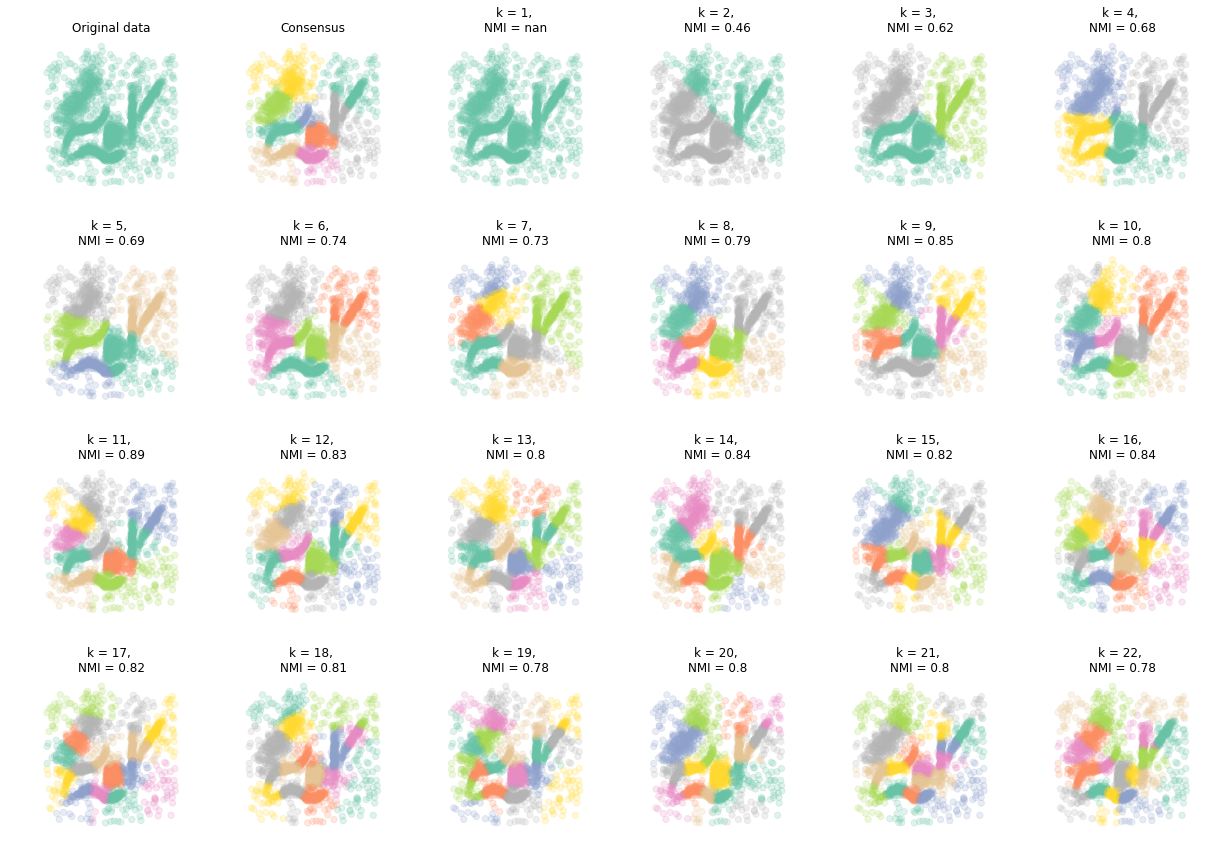

In [71]:
# Put labels in right order in to the labels array
labels = []
no_labels = [0] * len(data)
labels.append(no_labels)
labels.append(consensus_obj.cluster_labels)
for i in range(num_objects):
    labels.append(consensus_obj._noise_to_zero(cl_objects[i]).cluster_labels)
# labels.append(no_labels)
# for i in range(num_objects // 2, num_objects):
#     labels.append(consensus_obj._noise_to_zero(dbscan_objects[i]).cluster_labels)

# Init plotting arrangement
num_plots = len(cl_objects) + 2
num_subplts_per_row = 6
num_rows = num_plots // num_subplts_per_row
num_cols = min(num_subplts_per_row, num_plots)
f, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

# Plot labels
for i, ax in enumerate(axarr.flat):
    #format_square(ax, min(data[:, 0]), max(data[:, 0]), min(data[:, 1]), max(data[:, 1]))
    ax.set_aspect('equal')
    ax.scatter(data[:, 0], data[:, 1], s=40, c=labels[i], cmap='Set2', alpha=0.2)
    ax.axis('off')
#     if i < num_subplts_per_row - 1:
#         ax.set_title('eps = {:.2}, minPts = {:}\nNMI = {:.2}'.format(eps_arr[i], min_pts_arr[i], nmi_arr[i-1]))
#     elif i == num_subplts_per_row - 1:
#         ax.set_title('Original data')
#     elif i < num_plots - 1:
#         ax.set_title('eps = {:.2}, minPts = {:}\nNMI = {:.2}'.format(eps_arr[i-1], min_pts_arr[i-1], nmi_arr[i-1]))
#     else:
#         ax.set_title('Consensus')
    if i==0:
        ax.set_title('Original data')
    elif i==1:
        ax.set_title('Consensus')
    else:
        ax.set_title('k = {:}, \nNMI = {:.2}'.format(k_arr[i-2], nmi_arr[i-2]))
#         ax.set_title('eps = {:.2}, minPts = {:}\nNMI = {:.2}'.format(eps_arr[i-2], min_pts_arr[i-2], nmi_arr[i-2]))
        
plt.tight_layout()
plt.show()

In [20]:
#f.savefig('consensus_parameter_search.pdf', format='pdf')